# Attempting to extract params from multi-layered samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor, LayeredExtractorNK
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractorNKD

[((3.46+0.01j), 0.0005), ((2.5+0.015j), 0.00025)]


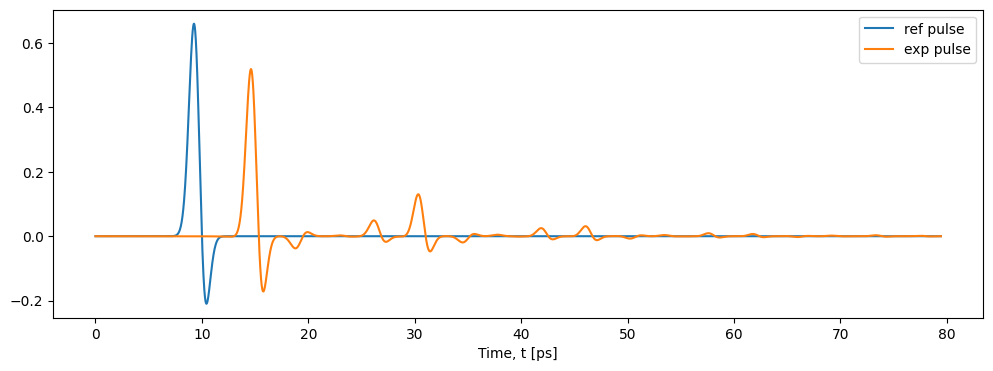

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 0.5e-3
n2, k2, d2= 2.5, 0.015, 0.25e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Test General model to fit all 3 parameters

Starting Bayesian Optimization for n, k, and D...
Search Boundaries:
Layer 1: n ∈ (3.34, 3.54), k ∈ (0.004999999999999999, 0.025), D ∈ (0.00045, 0.0007499999999999999)
Layer 2: n ∈ (2.35, 2.5500000000000003), k ∈ (0.007000000000000001, 0.027000000000000003), D ∈ (0.00015, 0.00045)
Bayesian Optimization complete.
[((3.3978929695619864+0.007376444698440749j), 0.000529502158371919), ((2.3672583512148+0.007000000000000001j), 0.00023851792222648736)]


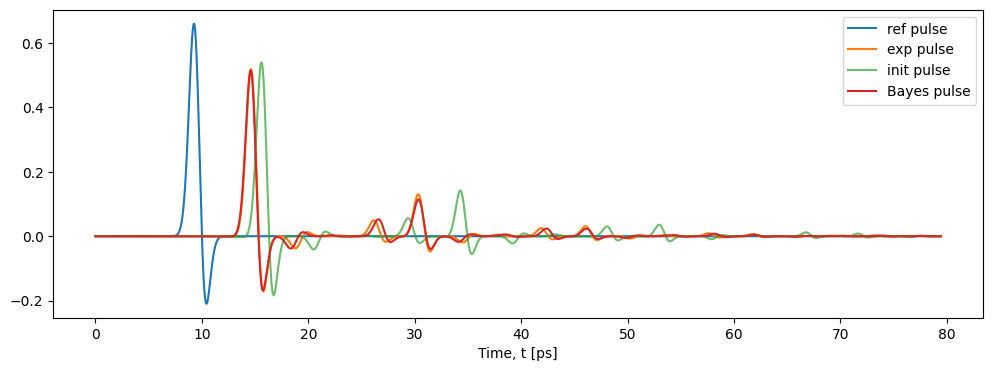

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_init = [(3.44+1j*0.015, 0.6e-3), (2.45+1j*0.017, 0.3e-3)]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractorNKD(reference_pulse, experimental_pulse, deltat, layers_init)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=60)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [7]:
# TODO: show residuals between (init, true) and (bayes, true)

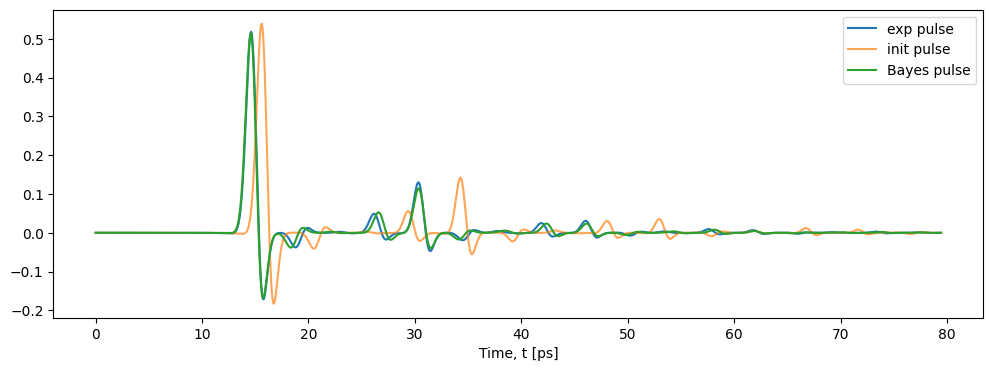

In [4]:
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, initial_pulse, label='init pulse', alpha=0.7)
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Optimizing for 100 iterations with loss multiplier 1.
Iteration 4, Loss: 0.010114889591932297, Layer 0: n=3.3933234214782715, k=-0.0027640382759273052, D=0.0005255240830592811, Layer 1: n=2.3729069232940674, k=-0.0010324660688638687, D=0.0002385851985309273
Iteration 9, Loss: 0.007893336936831474, Layer 0: n=3.401994466781616, k=0.009952939115464687, D=0.0005276692099869251, Layer 1: n=2.3935983180999756, k=0.016647914424538612, D=0.0002421189856249839
Iteration 14, Loss: 0.006261512637138367, Layer 0: n=3.3985133171081543, k=0.004107145592570305, D=0.0005229345988482237, Layer 1: n=2.405431032180786, k=0.01535138301551342, D=0.00024308677529916167
Iteration 19, Loss: 0.004814385902136564, Layer 0: n=3.3999764919281006, k=0.0045287394896149635, D=0.0005202596657909453, Layer 1: n=2.4230382442474365, k=0.020209994167089462, D=0.00024538522120565176
Iteration 24, Loss: 0.0037633157335221767, Layer 0: n=3.4033923149108887, k=0.0043236566707491875, D=0.0005179553991183639, Layer 1: n=2.443

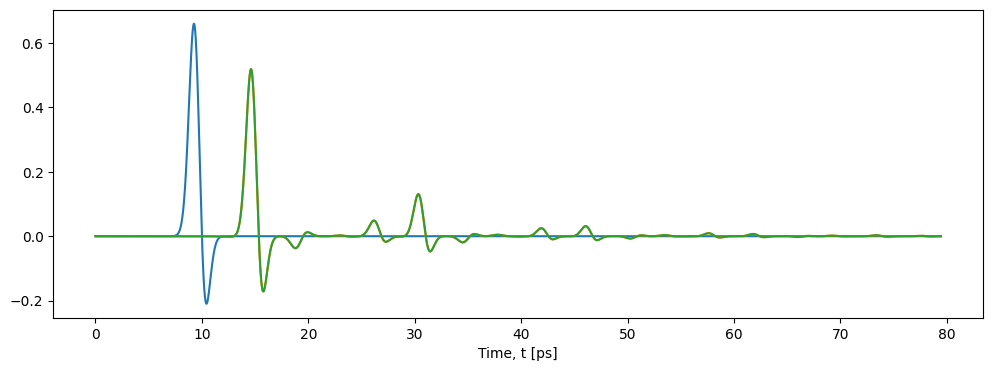

In [5]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.01)
nj,kj,dj = LE.optimize(num_iterations=100, updates=5 , alpha=1)

optim_params = [(nj[0]+1j*kj[0], dj[0]), (nj[1]+1j*kj[1], dj[1])]

_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.show()

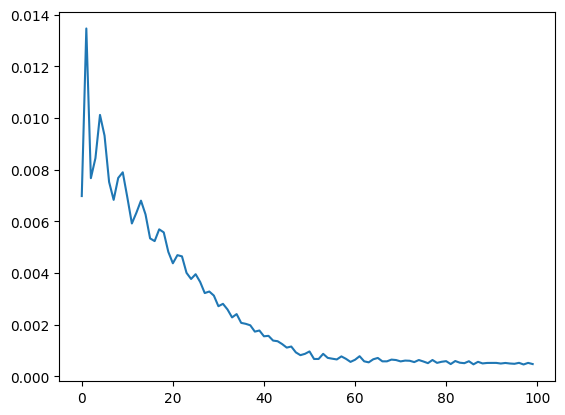

In [6]:
plt.plot(LE.loss_history)